# Нейронные сети
__Суммарное количество баллов: 10__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[ML][HW06] <ФИ>`, где вместо `<ФИ>` указаны фамилия и имя__

Для начала вам предстоит реализовать свой собственный backpropagation и протестировать его на реальных данных, а затем научиться обучать нейронные сети при помощи библиотеки `PyTorch` и использовать это умение для классификации классического набора данных CIFAR10.

In [4]:
import numpy as np
import copy
from sklearn.datasets import make_blobs, make_moons

### Задание 1 (3 балла)
Нейронные сети состоят из слоев, поэтому для начала понадобится реализовать их. Пока нам понадобятся только три:

`Linear` - полносвязный слой, в котором `y = Wx + b`, где `y` - выход, `x` - вход, `W` - матрица весов, а `b` - смещение. 

`ReLU` - слой, соответствующий функции активации `y = max(0, x)`.

`Softmax` - слой, соответствующий функции активации [softmax](https://ru.wikipedia.org/wiki/Softmax)


#### Методы
`forward(X)` - возвращает предсказанные для `X`. `X` может быть как вектором, так и батчем

`backward(d)` - считает градиент при помощи обратного распространения ошибки. Возвращает новое значение `d`

`update(alpha)` - обновляет веса (если необходимо) с заданой скоростью обучения

In [5]:
class Module:
    def forward(self, x):
        raise NotImplementedError()
    
    def backward(self, d):
        raise NotImplementedError()
        
    def update(self, alpha):
        pass
        
class Linear(Module):
    def __init__(self, in_features, out_features):
        self.in_f = in_features
        self.out_f = out_features
        self.W = np.random.rand(self.in_f, self.out_f) * 0.01
        self.b = np.zeros(self.out_f)
        self.x = None
        self.dw = None
        self.db = None
    
    def forward(self, x): 
        self.x = np.copy(x)
        if len(self.x.shape) == 1:
            self.x.reshape(1, self.x.shape[0])
        return np.dot(self.x, self.W) + self.b
    
    def backward(self, d):
        self.dw = np.dot(self.x.T, d)
        self.db = np.sum(d, axis = 0)
#         self.d.reshape(1, self.d.shape[0])
        return np.dot(d, self.W.T)
        
    def update(self, alpha):
        self.W = self.W - alpha * self.dw
        self.b = self.b - alpha * self.db
        
class ReLU(Module):
    def __init__(self):
        self.x = None
    
    def forward(self, x):
        self.x = np.copy(x)
        if len(self.x.shape) == 1:
            self.x.reshape(1, self.x.shape[0])
        return np.maximum(self.x, 0)
        
    def backward(self, d):
        ind = self.x > 0
        return d * ind
        
class Softmax(Module):
    def __init__(self):
        self.x = None
        self.p = None
        
    def forward(self, x):
        self.x = np.copy(x)
        if len(self.x.shape) == 1:
            self.x.reshape(1, self.x.shape[0])
        e = np.exp(self.x)
        self.p = e / np.sum(e, axis = 1, keepdims = True)

        return self.p
        
    def backward(self, y):
        
#         s = np.copy(self.x[np.arange(len(self.x)),y])

#         s = - s + np.log(np.sum(np.exp(self.x),axis=-1))
#         print(np.mean(s))
        
        d = np.copy(self.p)
        d[np.arange(self.x.shape[0]), y] -= 1
        return d / self.x.shape[0]

### Задание 2 (2 балла)
Теперь сделаем саму нейронную сеть.

#### Методы
`fit(X, y)` - обучает нейронную сеть заданное число эпох. В каждой эпохе необходимо использовать [cross-entropy loss](https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html#cross-entropy) для обучения, а так же производить обновления не по одному элементу, а используя батчи.

`predict_proba(X)` - предсказывает вероятности классов для элементов `X`

#### Параметры конструктора
`modules` - список, состоящий из ранее реализованных модулей и описывающий слои нейронной сети. В конец необходимо добавить `Softmax`

`epochs` - количество эпох обучения

`alpha` - скорость обучения

In [6]:
class MLPClassifier:
    def __init__(self, modules, epochs=100, alpha=0.01, batch_size = 100):
        self.modules = modules + [Softmax()]
        self.epochs = epochs
        self.alpha = alpha
        self.bs = batch_size
    
    
    def forward(self, X):
        cur = X
        for module in self.modules:
            cur = module.forward(cur)
        return cur
    
    def backward(self, d):
        cur = d
        for i, module in enumerate(reversed(self.modules)):
            cur = module.backward(cur)
    
    def update(self):
        for module in self.modules:
            if isinstance(module, Linear):
                module.update(self.alpha)

    def fit(self, X, y):
        for _ in range(self.epochs):
            bs = self.bs
            for j in range((len(X)+bs-1) // bs):
                cX = X[j*bs:j*bs+bs]
                cy = y[j*bs:j*bs+bs]

                self.forward(cX)
                self.backward(cy)
                self.update()
        
    def predict_proba(self, X):
        cur = X
        for i in range(len(self.modules)):
            cur = self.modules[i].forward(cur)
        return cur
        
    def predict(self, X):
        p = self.predict_proba(X)
        return np.argmax(p, axis=1)

In [7]:
p = MLPClassifier([
    Linear(4, 64),
    ReLU(),
    Linear(64, 64),
    ReLU(),
    Linear(64, 2)
], 4000, 0.1)

X = np.random.randn(50, 4)
y = [(0 if x[0] > x[2]**2 or x[3]**3 > 0.5 else 1) for x in X]
p.fit(X, y)

### Задание 3 (2 балла)
Протестируем наше решение на синтетических данных. Необходимо подобрать гиперпараметры, при которых качество полученных классификаторов будет достаточным.

#### Оценка
Accuracy на первом датасете больше 0.85 - +1 балл

Accuracy на втором датасете больше 0.85 - +1 балл

In [8]:
X, y = make_moons(400, noise=0.075)

In [9]:
X[[1,2,3]]

array([[-0.81365411,  0.64265519],
       [ 0.23060704,  0.93915233],
       [ 0.98279449,  0.03142884]])

In [10]:
X, y = make_moons(400, noise=0.075)
X_test, y_test = make_moons(400, noise=0.075)

best_acc = 0
for _ in range(1):
    p = MLPClassifier([
    Linear(2, 100),
    ReLU(),
    Linear(100, 27),
    ReLU(),
    Linear(27, 3)
    ], 1000, 0.1)

    p.fit(X, y)
    best_acc = max(np.mean(p.predict(X_test) == y_test), best_acc)
print("Accuracy", best_acc)

Accuracy 0.8875


In [11]:
X, y = make_blobs(400, 2, centers=[[0, 0], [2.5, 2.5], [-2.5, 3]])
X_test, y_test = make_blobs(400, 2, centers=[[0, 0], [2.5, 2.5], [-2.5, 3]])
best_acc = 0
for i in range(1):
    p = MLPClassifier([
    Linear(2, 100),
    ReLU(),
    Linear(100, 27),
    ReLU(),
    Linear(27, 3)
    ], 1000, 0.1)


    p.fit(X, y)
    best_acc = max(np.mean(p.predict(X_test) == y_test), best_acc)
print("Accuracy", best_acc)

Accuracy 0.94


## PyTorch

Для выполнения следующего задания понадобится PyTorch. [Инструкция по установке](https://pytorch.org/get-started/locally/)

Если у вас нет GPU, то можно использовать [Google Colab](https://colab.research.google.com/)

In [0]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
from tqdm import tqdm
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

t = transforms.ToTensor()

cifar_train = datasets.CIFAR10("datasets/cifar10", download=True, train=True, transform=t)
train_loader = DataLoader(cifar_train, batch_size=1024, shuffle=True, pin_memory=torch.cuda.is_available())
cifar_test = datasets.CIFAR10("datasets/cifar10", download=True, train=False, transform=t)
test_loader = DataLoader(cifar_test, batch_size=1024, shuffle=False, pin_memory=torch.cuda.is_available())

Files already downloaded and verified
Files already downloaded and verified


### Задание 4 (3 балла)
А теперь поработам с настоящими нейронными сетями и настоящими данными. Необходимо реализовать сверточную нейронную сеть, которая будет классифицировать изображения из датасета CIFAR10. Имплементируйте класс `Model` и функцию `calculate_loss`. 

Обратите внимание, что `Model` должна считать в конце `softmax`, т.к. мы решаем задачу классификации. Соответствеено, функция `calculate_loss` считает cross-entropy.

Для успешного выполнения задания необходимо, чтобы `accuracy`, `mean precision` и `mean recall` были больше 0.5

__Можно пользоваться всем содержимым библиотеки PyTorch.__

In [0]:
class Model(nn.Module):
    def __init__(self, n1, n2):
        super().__init__()
        self.layers = nn.ModuleList((nn.Linear(32*32*3, n1), nn.ReLU(),
                       nn.Linear(n1, n2), nn.ReLU(),
                       nn.Linear(n2, 10), nn.Softmax(dim=1)))
        
    def forward(self, x):
        x = x.reshape([x.shape[0], 32*32*3])
        for layer in self.layers:
            x = layer(x)
        return x

        
def calculate_loss(X, y, model):

    loss = nn.CrossEntropyLoss()
    res = model.forward(X)
    return loss(res, y)

Теперь обучим нашу модель. Для этого используем ранее созданные batch loader'ы.

In [0]:
def train(model, epochs=100):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    train_losses = []
    test_losses = []
    for i in range(epochs):
        #Train
        loss_mean = 0
        elements = 0
        for X, y in iter(train_loader):
            X = X.to(device)
            y = y.to(device)
            loss = calculate_loss(X, y, model)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_mean += loss.item() * len(X)
            elements += len(X)
        train_losses.append(loss_mean / elements)
        #Test
        loss_mean = 0 
        elements = 0
        for X, y in iter(test_loader):
            X = X.to(device)
            y = y.to(device)
            loss = calculate_loss(X, y, model)
            loss_mean += loss.item() * len(X)
            elements += len(X)
        test_losses.append(loss_mean / elements)
        print("Epoch", i, "| Train loss", train_losses[-1], "| Test loss", test_losses[-1])
    return train_losses, test_losses

In [67]:
model = Model(1000, 100).to(device)
train_l, test_l = train(model)

Epoch 0 | Train loss 2.2168932166290283 | Test loss 2.1624284496307373
Epoch 1 | Train loss 2.1386241943359376 | Test loss 2.126151993179321
Epoch 2 | Train loss 2.117949223098755 | Test loss 2.107931119918823
Epoch 3 | Train loss 2.0991981775665285 | Test loss 2.0983351211547854
Epoch 4 | Train loss 2.090396619338989 | Test loss 2.089881625366211
Epoch 5 | Train loss 2.0819976610565187 | Test loss 2.087142436981201
Epoch 6 | Train loss 2.0735295722198486 | Test loss 2.075954607772827
Epoch 7 | Train loss 2.06175860496521 | Test loss 2.075271621322632
Epoch 8 | Train loss 2.0664703466796874 | Test loss 2.0616686195373535
Epoch 9 | Train loss 2.05275888961792 | Test loss 2.0590393623352052
Epoch 10 | Train loss 2.0440520961761472 | Test loss 2.0544930168151856
Epoch 11 | Train loss 2.043223975067139 | Test loss 2.057649287414551
Epoch 12 | Train loss 2.0350893293762207 | Test loss 2.0572253875732422
Epoch 13 | Train loss 2.034312051010132 | Test loss 2.0454888683319092
Epoch 14 | Train 

Построим график функции потерь

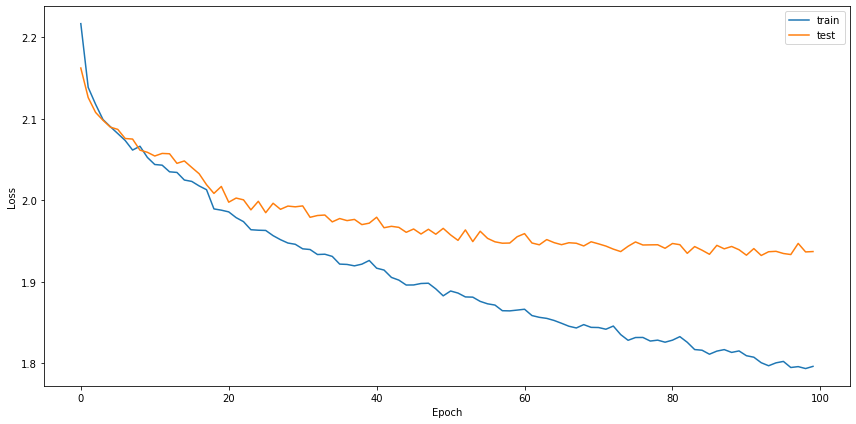

In [69]:
plt.figure(figsize=(12, 6))
plt.plot(range(len(train_l)), train_l, label="train")
plt.plot(range(len(test_l)), test_l, label="test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

И, наконец, посчитаем метрики

In [68]:
true_positive = np.zeros(10)
true_negative = np.zeros(10)
false_positive = np.zeros(10)
false_negative = np.zeros(10)
accuracy = 0
ctn = 0
for X, y in iter(test_loader):
    X = X.to(device)
    y = y.to(device)
    with torch.no_grad():
        y_pred = model(X).max(dim=1)[1]
    for i in range(10):
        for pred, real in zip(y_pred, y):
            if real == i:
                if pred == real:
                    true_positive[i] += 1
                else:
                    false_negative[i] += 1
            else:
                if pred == i:
                    false_positive[i] += 1
                else:
                    true_negative[i] += 1
            
    accuracy += torch.sum(y_pred == y).item()
    ctn += len(y)
print("Overall accuracy", accuracy / ctn)
print("Precision", true_positive / (true_positive + false_positive))
print("Recall", true_positive / (true_positive + false_negative))
print("Mean Precision", np.mean(true_positive / (true_positive + false_positive)))
print("Mean Recall", np.mean(true_positive / (true_positive + false_negative)))

Overall accuracy 0.5203
Precision [0.54655172 0.61724806 0.40737327 0.33743274 0.50307503 0.43391188
 0.6519945  0.59818731 0.60821918 0.55789474]
Recall [0.634 0.637 0.442 0.439 0.409 0.325 0.474 0.594 0.666 0.583]
Mean Precision 0.5261888439385471
Mean Recall 0.5203
